# Basic SACC example
This notebook contains the same code that appears one directory above in `create_sacc.py`, `load_sacc.py`, and `split_sacc.py`, that are referenced in the README at the top of the repository. If there is a difference between the two, those scripts are more up-to-date than this notebook.

## Creating the SACC
The first thing to do is to create the SACC object. Before we can even do that, we need to create some fake data that will go in the SACC.

In [1]:
import sacc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/anze/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Fake data
In this example, the fake data are some DES galaxies, some LSST galaxies, and a CMB kappa map. For all bins of each of these, we will create a `Tracer` object.

In [2]:
tracers = [] #The list to hold all tracers

Text(0,0.5,'N(z)')

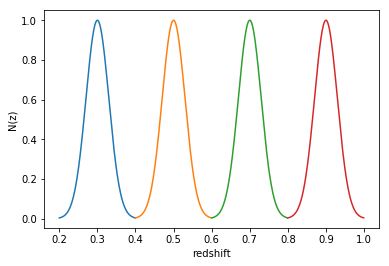

In [3]:
# First, generate 4 tomographic bins for the DES data.
for i,z in enumerate([0.3, 0.5, 0.7, 0.9]):
    zar=np.arange(z-0.1,z+0.1,0.001)
    Nz=np.exp(-(z-zar)**2/(2*0.03**2))
    bias=np.ones(len(zar))*(i+0.5)
    T=sacc.Tracer("des_gals_%i"%i,"spin0",zar,Nz,exp_sample="des_gals",
                               Nz_sigma_logmean=0.01, Nz_sigma_logwidth=0.1)
    T.addColumns({'b':bias})
    tracers.append(T)

    #Plotting, just to see what is going on
    plt.plot(zar, Nz)
plt.xlabel("redshift")
plt.ylabel("N(z)")

In [4]:
# Next LSST galaxies with 4 different tomographic bins.
# Here the PZ modelling got more advanced so we have some PZ shapes to marginalise over
for i,z in enumerate([0.5,0.7,0.9,1.1]):
    zar=np.arange(z-0.1,z+0.1,0.001)
    Nz=np.exp(-(z-zar)**2/(2*0.025**2))
    DNz=np.zeros((len(Nz),2))
    ## some random shapes of Nz to marginalise over
    DNz[:,0]=(z-zar)**2*0.01
    DNz[:,0]-=DNz[:,0].mean()
    DNz[:,1]=(z-zar)**3*0.01
    DNz[:,1]-=DNz[:,1].mean()
    bias=np.ones(len(zar))*(i+0.7)
    T=sacc.Tracer("lsst_gals_%i"%i,"spin0",zar,Nz,exp_sample="lsst_gals",
                               DNz=DNz)
    T.addColumns({'b':bias})
    tracers.append(T)

In [5]:
# Now let's also add the CMB kappa map, which will not actually have any data in it
# The two "None" arguments are z and Nz
tracers.append (sacc.Tracer("Planck","spin0", None, None))

### Data vectors and binning
The SACC holds data vectors and binning information. In this example, let's have cross-correlation of everything with everything else at 100 ell bins for density correlations.

In [6]:
lvals=np.arange(100,1000,100)
Ntracer=len(tracers)
#These lists will hold the information to create the "binning" object, which
#contains all information for the projected bins on the sky we are
#working with, or their Fourier-space equivalents (ells)
type,ell,t1,q1,t2,q2,val,err,wins=[],[],[],[],[],[],[],[],[]
#Loop over all tracers
for t1i in range(Ntracer):
    #Now loop over all *other* tracers
    for t2i in range(t1i,Ntracer):
        #For each ell bin
        for l in lvals:
            ## we have Fourier space measurement
            type.append('FF')
            ## at this nominal ell
            ell.append(l)
            ## but in detail  the measurement
            ## is a Gaussian window around central ell +/- 50
            wins.append(sacc.Window(np.arange(l-50,l+50),np.exp(-(1.0*np.arange(-50,50))**2/(2*20.**2))))
            ## We refer to tracers by their index
            t1.append(t1i)
            t2.append(t2i)
            ## Here we have density cross-correlations so "P" as point
            ## except for CMB where 
            q1.append('S')
            q2.append('S')
            ## values and errors for the fake data
            val.append(np.random.uniform(0,10))
            err.append(np.random.uniform(1,2))

#Create the binning object
binning=sacc.Binning(type,ell,t1,q1,t2,q2,windows=wins)
#Also retrieve the vector of mean values of the fake data
mean=sacc.MeanVec(val)

### Covariance matrices
Finally, the SACC object holds a covariance matrix between all of the data we use. We will use ell_block_diagonal where everything is coupled across tracers/redshifts at the same ell but not across ell with fixed 10% off-diagonal elements.

In [7]:
#Obtain the size of the binning, or the number of radial bins we have.
Np=binning.size()
#Create the object that will hold the covariance.
cov=np.zeros ((Np,Np))
#Loop over all bins
for i in range(Np):
    #Loop over all i:Np bins
    for j in range (i,Np):
        #If the bins are the same, then there is covariance between the tracers.
        #In the off-diagonals, reduce the covairance by a factor of 10.
        if ell[i]==ell[j]:
            cov[i,j]=err[i]*err[j]
            if (i!=j):
                cov[i,j]/=10
            cov[j,i]=cov[i,j]
#SACC objects actually save the precision matrix, which we can conveniently obtain
#from the covairance using this function, which also associates a name and a binning
#to the matrix.
precision=sacc.Precision(cov,"ell_block_diagonal",is_covariance=True, binning=binning)

In [8]:
## Add some meta data
meta={"Creator":"McGyver","Project":"Victory"}
# Saving the SACC is easy, and it combines all the parts we just computed
s=sacc.SACC(tracers,binning,mean,precision,meta)
s.printInfo()
s.saveToHDF ("test.sacc")

--------------------------------
Meta information:
   Creator : McGyver
   Project : Victory
--------------------------------
 EXP_SAMPLE: None
       Tomographic sample #0: <z>=-1.00
 EXP_SAMPLE: des_gals
       Tomographic sample #0: <z>=0.30
       Tomographic sample #1: <z>=0.50
       Tomographic sample #2: <z>=0.70
       Tomographic sample #3: <z>=0.90
 EXP_SAMPLE: lsst_gals
       Tomographic sample #0: <z>=0.50
       Tomographic sample #1: <z>=0.70
       Tomographic sample #2: <z>=0.90
       Tomographic sample #3: <z>=1.10
--------------------------------
Total number of points: 405
Precision matrix type: ell_block_diagonal


## Loading the SACC
SACCs can be created in one place and loaded into another. These next two cells show how you can load up the SACC, and then print some handy information from inside.

In [9]:
s=sacc.SACC.loadFromHDF("test.sacc")
s.printInfo()

--------------------------------
Meta information:
   Creator : b'McGyver'
   Project : b'Victory'
--------------------------------
 EXP_SAMPLE: b'None'
       Tomographic sample #0: <z>=-1.00
 EXP_SAMPLE: b'lsst_gals'
       Tomographic sample #0: <z>=0.50
       Tomographic sample #1: <z>=0.70
       Tomographic sample #2: <z>=0.90
       Tomographic sample #3: <z>=1.10
 EXP_SAMPLE: b'des_gals'
       Tomographic sample #0: <z>=0.30
       Tomographic sample #1: <z>=0.50
       Tomographic sample #2: <z>=0.70
       Tomographic sample #3: <z>=0.90
--------------------------------
Total number of points: 405
Precision matrix type: ell_block_diagonal


In [10]:
print ("Precision matrix, first 10 colums:")
## This will invert matrix from covariance on the fly
m=s.precision.precisionMatrix()
Ncol = 10
for i in range(Ncol):
    for j in range(Ncol):
        print ('%5.5f '%m[i,j],end="")
    print()

Precision matrix, first 10 colums:
0.73145 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 -0.00889 
0.00000 0.38780 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
0.00000 0.00000 0.78504 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
0.00000 0.00000 0.00000 0.40189 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
0.00000 0.00000 0.00000 0.00000 0.57786 0.00000 0.00000 0.00000 0.00000 0.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.82915 0.00000 0.00000 0.00000 0.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.65858 0.00000 0.00000 0.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.80344 0.00000 0.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.31967 0.00000 
-0.00889 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.30372 


## Splitting the SACC
The SACC can also be saved into individual parts, meaning we can save the mean vector, precision matrix, etc. to separate files. 

In [11]:
#Load the SACC created earlier.
s=sacc.SACC.loadFromHDF("test.sacc")
#Save the mean vector and precision matrix separately.
s.mean.saveToHDFFile("split.mean.sacc")
s.precision.saveToHDFFile("split.precision.sacc")
s.saveToHDF("split.main.sacc",save_mean=False, mean_filename="split.mean.sacc",
                              save_precision=False, precision_filename="split.precision.sacc")

In [12]:
#We can now reload, and the SACC will be reconsituted from three files.
sn=sacc.SACC.loadFromHDF("split.main.sacc")
sn.printInfo()

--------------------------------
Meta information:
   Creator : b'McGyver'
   Project : b'Victory'
--------------------------------
 EXP_SAMPLE: b"b'des_gals'"
       Tomographic sample #0: <z>=0.30
       Tomographic sample #1: <z>=0.50
       Tomographic sample #2: <z>=0.70
       Tomographic sample #3: <z>=0.90
 EXP_SAMPLE: b"b'None'"
       Tomographic sample #0: <z>=-1.00
 EXP_SAMPLE: b"b'lsst_gals'"
       Tomographic sample #0: <z>=0.50
       Tomographic sample #1: <z>=0.70
       Tomographic sample #2: <z>=0.90
       Tomographic sample #3: <z>=1.10
--------------------------------
Total number of points: 405
Precision matrix type: ell_block_diagonal
